# Step 1. Import packages

In [1]:
import numpy as np
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Seq import Seq
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from scipy.integrate import simpson
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px

workdir = "./"
fig_dir = "./Figures/"

# Step 1-1. Helper functions

In [6]:
primer = "GCGCAGGTAGCACTTTTC"
refSeq = "GAATAGCGACGCCGAGCTCGTGGAGCTGTCCGGCGACACCCTGGAAGCCATCC"
len_amplicon = 90
# If you use have a single mutant library and know all the sequences:

TnsC_dict = workdir + "TnsC_dict_bar.txt"

def txt2list(file):
    with open(file) as f:
        lst = f.readlines()
    return lst

def read_dict(file):
    lst = txt2list(file)
    TnsC_dict = {} 
    read = False
    for line in lst:
        if line.startswith(">"):
            library_name = line[1:].strip()
            read = True 
        elif read:
            seq = line[0:len_amplicon] 
            TnsC_dict[seq] = library_name 
            read = False
    return TnsC_dict

In [7]:
def process_seq(seqs,primer,len_amplicon):
    """
    Processes a list of sequences to find the offset using a primer, translates the sequence if its size matches the reference,
    and identifies mutations.

    Parameters:
    seqs (list of str): List of DNA sequences to be processed.
    primer (str): The primer sequence used to find the offset.
    len_amplicon (int): The length of the reference sequence.

    Returns:
    list: A list of processed sequence information. Each element is a list containing:
        - Nucleotide sequence of barcodes or 0 if size does not match reference
        - Read number of barcodes (int)
        - Read number of variants (int)
        - Name of TnsC variants (str)
        - Name of barcodes (str)
    """
    rseqs=[]
    for seq in seqs:
        offset=seq.rfind(primer)+len(primer)
        wo_offset_seq=seq[offset:offset+len_amplicon]
        
        if len(wo_offset_seq) == len_amplicon:
            try:
                library_name = TnsC_DMS[wo_offset_seq]
                match = re.match(r'([A-Za-z0-9_*]+)_B(\d+)', library_name)

                if match:
                    main_library_name = match.group(1)
                    barcode_suffix = match.group(2)
                else:
                    main_library_name = library_name
                    barcode_suffix = None
                if main_library_name == 'TnsC_WT':
                    mut_aa = 'WT'
                else:
                    mut_aa = main_library_name[5:]
                barcode = library_name[5:]
                rseqs.append([wo_offset_seq, mut_aa, barcode])

            except KeyError:
                rseqs.append([0, 0])
                continue

        else:
            rseqs.append([0, 0])

    return rseqs

def generate_df(file, primer, len_amplicon, nc=20,nt_counts=10,aa_counts=0,batch_size=100000):
    """
    Generates a DataFrame from a FASTQ file containing DNA sequences, processes the sequences to find mutations, and filters the results.

    Parameters:
    file (str): Path to the FASTQ file.
    primer (str): The primer sequence used to find the offset.
    len_amplicon (int): The length of the reference sequence.
    nc (int): Number of CPU cores to use for parallel processing.
    nt_counts (int): Minimum number of reads for nucleotide sequences to be included in the final DataFrame.
    aa_counts (int): Minimum number of reads for amino acid sequences to be included in the final DataFrame.
    batch_size (int): Number of sequences to process in each batch.

    Returns:
    DataFrame: A DataFrame containing information about the processed sequences and their mutations.
    """
    print('Processing ',file)
    #Load file
    fastq_gen = FastqGeneralIterator(open(file))
    seqs=[i[1] for i in fastq_gen]
    #Translate and filter nucleotides sequences
    print('Linking Barcodes with variants')
    out=Parallel(n_jobs=nc)(delayed(process_seq)(seqs[i:i+batch_size], primer, len_amplicon) for i in tqdm(range(0,len(seqs),batch_size)))
    results=[]
    for i in range(len(out)):
        for j in out[i]:
            results.append(j)
            
    good_seqs=np.array([r[0]!=0 for r in results])
    print('Number of senquences with the right length: ',np.sum(good_seqs),'out of ',len(seqs))
    del seqs
    results=[results[i] for i in range(len(results)) if good_seqs[i]==True]
    results=np.array(results,dtype=object)
    #results[results=='']='WT'
    #Merge information into data frame
    d = {'Barcode_seq': results[:, 0],
        'AA_mut_list': results[:, 1],
        'Barcode_name': results[:, 2]}
    df = pd.DataFrame(data=d)
    df=df[np.array([not 'N' in i for i in df['Barcode_seq']])]
    #Remove duplicates while keeping reads
    counts=df['AA_mut_list'].value_counts()
    df['reads_AA']=df['AA_mut_list'].map(counts)
    counts=df['Barcode_name'].value_counts()
    df['reads_Bar']=df['Barcode_name'].map(counts)
    df = df.drop_duplicates(subset=['AA_mut_list', 'Barcode_name'])
    #Compute frequency of each variant
    df['freq_AA']=df['reads_AA']/np.sum(df['reads_Bar'])
    df['freq_Bar']=df['reads_Bar']/np.sum(df['reads_Bar'])
    #Filter for low reads
    df=df[(df['reads_AA']>aa_counts)*(df['reads_Bar']>nt_counts)]

    print(len(df),'variants with more than',nt_counts,'reads and with no X in AA sequence')
    
    return df

def create_df(data):
    """
    Creates a DataFrame from a numpy array with mutation and sequence data.

    Parameters:
    data (numpy.ndarray): A 2D numpy array where each row contains:
        - AA_mut_list (str): List of amino acid mutations.
        - Barcode_name (str): List of barcodes.
        - Barcode_seq (str): Barocde sequence.
        - reads_AA (int): Read count for each TnsC variants
        - reads_Bar (int): Read count for each barcodes.
        - freq_AA (float): Frequency of each TnsC variants.
        - freq_Bar (float): Frequency of each barcodes.

    Returns:
    DataFrame: A pandas DataFrame containing the provided data with appropriate column names.
    """
    df = {
            'Barcode_seq': pd.Series(data[:,0]),
            'AA_mut_list': pd.Series(data[:,1]),
            'Barcode_name': pd.Series(data[:,2]),       
            'reads_AA': pd.Series(data[:,3]),
            'reads_Bar': pd.Series(data[:,4]),
            'freq_AA': pd.Series(data[:,5]),
            'freq_Bar': pd.Series(data[:,6])
    }
    return pd.DataFrame(df)


# Step 2. Process Fastq data 
### Skip this step if processed data file (./data_kan_ara_filter.npy) is present

In [ ]:
the=0
print('Counts thershole',the)
df_input_R1=generate_df(workdir+'TnsC_R1_input.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_input_R2=generate_df(workdir+'TnsC_R2_input.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Kan_R1=generate_df(workdir+'TnsC_R1_Kan.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Kan_R2=generate_df(workdir+'TnsC_R2_Kan.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Ara_R1=generate_df(workdir+'TnsC_R1_Ara.fastq', primer, len_amplicon, nc=20, nt_counts=the)
df_Ara_R2=generate_df(workdir+'TnsC_R1_Ara.fastq', primer, len_amplicon, nc=20, nt_counts=the)

# Save processed data
with open(workdir + 'TnsC_data_kan_ara.npy', 'wb') as f:
    np.save(f, df_input_R1) 
    np.save(f, df_input_R2)
    np.save(f, df_Kan_R1)
    np.save(f, df_Kan_R2)
    np.save(f, df_Ara_R1)
    np.save(f, df_Ara_R2)

# Step 3. Merge data from Kan, Ara and Input
### Load processed data saved in data_kan_ara.npy 

In [8]:
def merged_df_readBar(d1,d2,suffixes,the):
    d1 = d1[(d1['reads_Bar'] > the) & (d1['reads_AA'] > 50)]
    df12 = pd.merge(d1, d2, on=['Barcode_seq', 'AA_mut_list', 'Barcode_name'], suffixes=suffixes)
    #df12 = pd.merge(d1, d2, on=['Barcode_seq', 'AA_mut_list', 'Barcode_name'], how='left', suffixes=suffixes)
    #df12 = df12.replace(np.nan, 0)
    #Get relative change in frequency
    wt_d1=np.array(df12[df12['AA_mut_list']=='WT']['reads_Bar'+suffixes[0]],dtype=float)+0.5
    wt_d2=np.array(df12[df12['AA_mut_list']=='WT']['reads_Bar'+suffixes[1]],dtype=float)+0.5
    tr_d1=np.sum(df12['reads_Bar'+suffixes[0]])
    tr_d2=np.sum(df12['reads_Bar'+suffixes[1]]) 
    wt_rel_change=(wt_d2/tr_d2)/(wt_d1/tr_d1)
    indx = np.argmin(np.fabs(wt_rel_change-np.median(wt_rel_change)))
    #Select barcode closest to the median
    wt_barcode=df12[df12['AA_mut_list']=='WT'].iloc[indx]['Barcode_name']
    print('WT referece barcode:',wt_barcode)
    wt_sel=d2[d2['Barcode_name']==wt_barcode]['reads_Bar'].values[0]+0.5
    wt_inp=d1[d1['Barcode_name']==wt_barcode]['reads_Bar'].values[0]+0.5
    counts_sel=np.array(df12['reads_Bar'+suffixes[1]].values,dtype=float)+0.5
    counts_inp=np.array(df12['reads_Bar'+suffixes[0]].values,dtype=float)+0.5
    enrich=np.log2(counts_sel/wt_sel) - np.log2(counts_inp/wt_inp)
    df12['enrich'+suffixes[1]]=enrich
    s=1/wt_sel + 1/wt_inp + 1/(df12['reads_Bar'+suffixes[1]]+0.5).values + 1/(df12['reads_Bar'+suffixes[0]]+0.5).values
    df12['stderr'+suffixes[1]]=np.sqrt(np.array(s,dtype=float))
    return df12
    
def merged_df_replicates(d1,d2,suffixes):
    """
    Merges two DataFrames on nucleotide and amino acid mutation information.

    Parameters:
    d1 (DataFrame): First DataFrame containing mutation and sequence data.
    d2 (DataFrame): Second DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    DataFrame: A merged DataFrame containing columns from both input DataFrames.
    """
    df12=pd.merge(d1, d2, on=['Barcode_name','AA_mut_list','Barcode_seq'],suffixes=suffixes)
    return df12

def mut_in_context(df,suffixes,mutation,style):
    """
    Plots the enrichment score of a specific mutation in the context of wild-type synonymous mutations.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    mutation (str): The specific mutation to highlight in the plot.
    style (str): The style of the plot, specifying which column to use for the x-axis.
    """
    mut=mutation
    fig=plt.figure(figsize=(3,2))
    ax=fig.add_subplot(111)
    ax.set_title(mut+' '+style+' in\ncontext of WT syn mut')
    kernel = stats.gaussian_kde(df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]])

    sub_df=df[df['AA_mut_list']==mut]
    ax.errorbar(sub_df[style].values[0],[0.4],xerr=sub_df['stderr'].values[0],capsize=5,color='k',barsabove=False)
    ax.scatter(sub_df['enrich'+suffixes[0]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    ax.scatter(sub_df['enrich'+suffixes[1]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    scatter=ax.scatter(sub_df[style].values[0],[0.4],c=sub_df['stderr'].values[0],
            cmap='RdBu_r',vmin=0,vmax=df['stderr'].max(),edgecolor='k')
    x=np.linspace(-5,5,50)
    ax.plot(x,kernel(x)/4,color='k')
    ax.plot(x,-kernel(x)/4,color='k')
    ax.fill_between(x,kernel(x)/4,-kernel(x)/4,edgecolor='gray',facecolor='gray')

    ax.set_xlabel('Score')
    ax.set_yticks([])
    ax.set_ylim([-0.3,0.7])
    ax.legend([f"P-value={sub_df['pvalues'].values[0]:.2e}"])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(scatter, cax=cax, orientation='vertical',label='stderr')

def score_n_error(df,mut,suffixes):
    """
    Calculates the score and error for a specific mutation using weighted averages and iterative refinement.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    sub_df=df[df['AA_mut_list']==mut]
    replicates=2*len(sub_df)
    scores=np.concatenate([sub_df['enrich'+suffixes[0]].values,sub_df['enrich'+suffixes[1]].values])
    errors=np.concatenate([sub_df['stderr'+suffixes[0]].values,sub_df['stderr'+suffixes[1]].values])
    error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
    tmp_error=error
    for _ in range(50):
        num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
        den=np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_beta=num/den
        num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
        den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_error=np.sqrt(tmp_error*num/den)
    return tmp_beta, tmp_error  
   
def rep_score_n_error(df,mut,suffix):
    """
    Computes the enrichment score and error for a specific mutation, using weighted averages and iterative refinement.
    If there is only one biological replicate, returns the score and error directly.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffix (str): Suffix to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    #Computes ENRICH2 UNLESS there are no biological replicates in the technical replcate
    sub_df=df[df['AA_mut_list']==mut]
    replicates=len(sub_df)
    if replicates!=1:
        scores=sub_df['enrich'+suffix].values
        errors=sub_df['stderr'+suffix].values
        error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
        tmp_error=error
        for _ in range(50):
            num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
            den=np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_beta=num/den
            num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
            den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_error=np.sqrt(tmp_error*num/den)
    else:
        tmp_beta = sub_df['enrich'+suffix].values[0]
        tmp_error = sub_df['stderr'+suffix].values[0]
    return tmp_beta, tmp_error

def p_values(df,mut,suffixes):
    """
    Computes the p-value for the enrichment scores of a specific mutation compared to wild-type using the Mann-Whitney U test.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the p-value for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    float: The p-value from the Mann-Whitney U test comparing the mutation to wild-type.
    """
    sub_df=df[df['AA_mut_list']==mut]
    wt_values=np.concatenate([df[df['AA_mut_list']=='WT']['enrich'+suffixes[0]],df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]]])
    mut_values=np.concatenate([sub_df['enrich'+suffixes[0]],sub_df['enrich'+suffixes[1]]])
    _, p = stats.mannwhitneyu(wt_values,mut_values)
    return p

In [9]:
# Load processed data
with open(workdir + 'TnsC_data_kan_ara.npy', 'rb') as f:
    df_input_R1=create_df(np.load(f,allow_pickle=True))
    df_input_R2=create_df(np.load(f,allow_pickle=True))
    df_Kan_R1=create_df(np.load(f,allow_pickle=True))
    df_Kan_R2=create_df(np.load(f,allow_pickle=True))
    df_Ara_R1=create_df(np.load(f,allow_pickle=True))
    df_Ara_R2=create_df(np.load(f,allow_pickle=True))

In [10]:
def score_n_error_barcode(df,mut,suffixes):
    """
    Calculates the score and error for a specific mutation using weighted averages and iterative refinement.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    sub_df=df[df['AA_mut_list']==mut]

    valid_1 = sub_df['reads_AA' + suffixes[0]] != 0
    enrich_1 = sub_df.loc[valid_1, 'enrich' + suffixes[0]].values
    stderr_1 = sub_df.loc[valid_1, 'stderr' + suffixes[0]].values

    valid_2 = sub_df['reads_AA' + suffixes[1]] != 0
    enrich_2 = sub_df.loc[valid_2, 'enrich' + suffixes[1]].values
    stderr_2 = sub_df.loc[valid_2, 'stderr' + suffixes[1]].values

    scores = np.concatenate([enrich_1, enrich_2])
    errors = np.concatenate([stderr_1, stderr_2])

    replicates = len(scores)
    error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
    tmp_error=error
    for _ in range(50):
        num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
        den=np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_beta=num/den
        num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
        den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_error=np.sqrt(tmp_error*num/den)
    return tmp_beta, tmp_error  
    
def rep_score_n_error_barcode(df,mut,suffix):
    """
    Computes the enrichment score and error for a specific mutation, using weighted averages and iterative refinement.
    If there is only one biological replicate, returns the score and error directly.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffix (str): Suffix to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    #Computes ENRICH2 UNLESS there are no biological replicates in the technical replcate
    sub_df=df[df['AA_mut_list']==mut]
    valid_rows = sub_df['reads_AA' + suffix] != 0
    filtered_df = sub_df[valid_rows]
    replicates=len(filtered_df)
    epsilon = 1e-10
    if replicates != 1:
        scores=filtered_df['enrich'+suffix].values
        errors=filtered_df['stderr'+suffix].values
        error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
        tmp_error=error
        for _ in range(50):
            num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
            den=np.sum(((tmp_error**2 + errors**2)**-1))
            if abs(den) < 1e-12:
                den += epsilon
            tmp_beta=num/den
            num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
            den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/(np.sum(((tmp_error**2 + errors**2)**-1)) + epsilon)
            if den <= 0:
                print(f"경고: 분모가 0 이하. mut: {mut}, tmp_error: {tmp_error}, errors: {errors}")
                return np.mean(scores), np.mean(errors)
            tmp_error=np.sqrt(tmp_error*num/den)
    else:
        tmp_beta = filtered_df['enrich'+suffix].values[0]
        tmp_error = filtered_df['stderr'+suffix].values[0]
    return tmp_beta, tmp_error

def p_values_barcodes(df,mut,suffixes):
    """
    Computes the p-value for the enrichment scores of a specific mutation compared to wild-type using the Mann-Whitney U test.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the p-value for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    float: The p-value from the Mann-Whitney U test comparing the mutation to wild-type.
    """
    wt_r1 = df[(df['AA_mut_list'] == 'WT') & (df['reads_AA' + suffixes[0]] != 0)]
    wt_r2 = df[(df['AA_mut_list'] == 'WT') & (df['reads_AA' + suffixes[1]] != 0)]
    wt_values = np.concatenate([wt_r1['enrich' + suffixes[0]], wt_r2['enrich' + suffixes[1]]])
    
    sub_df=df[df['AA_mut_list']==mut]
    mut_r1 = sub_df[sub_df['reads_AA' + suffixes[0]] != 0]
    mut_r2 = sub_df[sub_df['reads_AA' + suffixes[1]] != 0]
    mut_values = np.concatenate([mut_r1['enrich' + suffixes[0]], mut_r2['enrich' + suffixes[1]]])
    _, p = stats.mannwhitneyu(wt_values,mut_values)
    return p

In [11]:
read_filter=10
df_Kan_input_R1=merged_df_readBar(df_input_R1,df_Kan_R1,['_input','_Kan'],the=read_filter)
df_Kan_input_R2=merged_df_readBar(df_input_R2,df_Kan_R2,['_input','_Kan'],the=read_filter)
df_Ara_input_R1=merged_df_readBar(df_input_R1,df_Ara_R1,['_input','_Ara'],the=read_filter)
df_Ara_input_R2=merged_df_readBar(df_input_R2,df_Ara_R2,['_input','_Ara'],the=read_filter)
df_Kan_Ara_R1=merged_df_readBar(df_Kan_R1,df_Ara_R1,['_Kan','_Ara'],the=read_filter)
df_Kan_Ara_R2=merged_df_readBar(df_Kan_R2,df_Ara_R2,['_Kan','_Ara'],the=read_filter)

WT referece barcode: WT_B7156
WT referece barcode: WT_B2747
WT referece barcode: WT_B460
WT referece barcode: WT_B3561
WT referece barcode: WT_B5202
WT referece barcode: WT_B1569


In [12]:
df_Kan_input=merged_df_replicates(df_Kan_input_R1,df_Kan_input_R2,['_R1','_R2'])
df_Ara_input=merged_df_replicates(df_Ara_input_R1,df_Ara_input_R2,['_R1','_R2'])
df_Kan_Ara=merged_df_replicates(df_Kan_Ara_R1,df_Kan_Ara_R2,['_R1','_R2'])

In [13]:
unique_count = df_Kan_input['AA_mut_list'].nunique()
print(f"Unique rows count: {unique_count}")

Unique rows count: 5523


# Step 3-1. Score Calculation
### Skip this step if processed cvs files are present

In [6]:
# Process Kanamycin input data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    tmp_dict={}
    scores = []
    errors = []
    for i in range(len(df_Kan_input)):
        if df_Kan_input['AA_mut_list'][i] in tmp_dict.keys():
            s, e = tmp_dict[df_Kan_input['AA_mut_list'][i]][0], tmp_dict[df_Kan_input['AA_mut_list'][i]][1]
        else:
            s, e = rep_score_n_error(df_Kan_input, df_Kan_input['AA_mut_list'][i], '_Kan_' + rep)
            tmp_dict[df_Kan_input['AA_mut_list'][i]]=[s,e]
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Kan_input['activity_' + rep] = scores
    df_Kan_input['stderr_' + rep] = errors

# Process Ara input data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    tmp_dict={}
    scores = []
    errors = []
    for i in range(len(df_Kan_Ara)):
        if df_Kan_Ara['AA_mut_list'][i] in tmp_dict.keys():
            s, e = tmp_dict[df_Kan_Ara['AA_mut_list'][i]][0], tmp_dict[df_Kan_Ara['AA_mut_list'][i]][1]
        else:
            s, e = rep_score_n_error(df_Kan_Ara, df_Kan_Ara['AA_mut_list'][i], '_Ara_' + rep)
            tmp_dict[df_Kan_Ara['AA_mut_list'][i]]=[s,e]
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Kan_Ara['specificity_' + rep] = scores
    df_Kan_Ara['stderr_' + rep] = errors

NameError: name 'df_Kan_input' is not defined

In [ ]:
tmp_dict={}
scores=[]
errors=[]
pvalue=[]
variant=[]
for i in range(len(df_Kan_input)):
    if df_Kan_input['AA_mut_list'][i] in tmp_dict.keys():
        s, e, p = tmp_dict[df_Kan_input['AA_mut_list'][i]][0], tmp_dict[df_Kan_input['AA_mut_list'][i]][1], tmp_dict[df_Kan_input['AA_mut_list'][i]][2]
    else:
        s,e= score_n_error(df_Kan_input,df_Kan_input['AA_mut_list'][i],['_Kan_R1','_Kan_R2'])
        p = p_values(df_Kan_input,df_Kan_input['AA_mut_list'][i],['_Kan_R1','_Kan_R2'])
        tmp_dict[df_Kan_input['AA_mut_list'][i]] = [s,e,p]
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Kan_input['activity']=scores
df_Kan_input['stderr']=errors
df_Kan_input['pvalues']=pvalue

tmp_dict={}
scores=[]
errors=[]
pvalue=[]
variant=[]
for i in range(len(df_Kan_Ara)):
    if df_Kan_Ara['AA_mut_list'][i] in tmp_dict.keys():
        s, e, p = tmp_dict[df_Kan_Ara['AA_mut_list'][i]][0], tmp_dict[df_Kan_Ara['AA_mut_list'][i]][1], tmp_dict[df_Kan_Ara['AA_mut_list'][i]][2]
    else:
        s,e= score_n_error(df_Kan_Ara,df_Kan_Ara['AA_mut_list'][i],['_Ara_R1','_Ara_R2'])
        p = p_values(df_Kan_Ara,df_Kan_Ara['AA_mut_list'][i],['_Ara_R1','_Ara_R2'])
        tmp_dict[df_Kan_Ara['AA_mut_list'][i]] = [s,e,p]
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Kan_Ara['specificity']=scores
df_Kan_Ara['stderr']=errors
df_Kan_Ara['pvalues']=pvalue

In [ ]:
#Save processed dataframes 
df_Kan_input.to_csv('activity_full_dataframe.csv')
df_Kan_Ara.to_csv('specificity_full_dataframe.csv')

In [ ]:
df_Kan_input.drop_duplicates(subset='AA_mut_list')[['AA_mut_list','activity','stderr','activity_R1','stderr_R1','activity_R2','stderr_R2']].to_csv('activity_simple_dataframe.csv')
df_Kan_Ara.drop_duplicates(subset='AA_mut_list')[['AA_mut_list','specificity','stderr','specificity_R1','stderr_R1','specificity_R2','stderr_R2']].to_csv('specificity_simple_dataframe.csv')

# Step 3-2. Load score data

In [14]:
df_Kan_input = pd.read_csv('TnsC_activity_full_dataframe.csv')
df_Kan_Ara = pd.read_csv('TnsC_specificity_full_dataframe.csv')

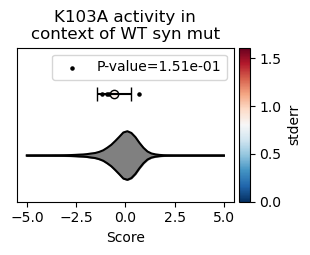

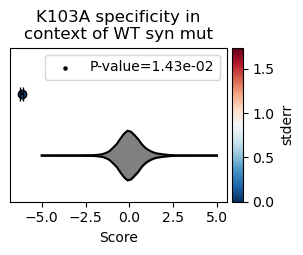

In [15]:
mut_in_context(df_Kan_input,['_Kan_R1','_Kan_R2'],'K103A','activity')
mut_in_context(df_Kan_Ara,['_Ara_R1','_Ara_R2'],'K103A','specificity')

# Step 4. Scatter plot between Replicates

In [16]:
def replicate_scatter(df, data_type, the):
    """
    Plot a scatter between two repliacates with Pearson correlation

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        data_type (str) : activity or specificity
        the (float) : error thereshold
    Returns:
        fig
    """
    filtered_df = df[(df['stderr_R1'] <= the) & (df['stderr_R2'] <= the)]
    df_unique = filtered_df.drop_duplicates(subset='AA_mut_list')
    x = df_unique[data_type+'_R1']
    y = df_unique[data_type+'_R2']
    names = df_unique['AA_mut_list']
    #Pearson
    pearson_corr, _ = pearsonr(x, y)
    #Number of dots
    num_dots = len(x)
    print(f"Number of total points: {num_dots}")
    
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c='black', s=10, alpha=0.4)
    plt.axhline(y=0, linewidth=1, color='k')
    plt.axvline(x=0, linewidth=1, color='k')
    # regression line
    sns.regplot(x=x, y=y, scatter=False, color='red', line_kws={'label': f'Regression Line (r={pearson_corr:.2f})'})
    plt.text(0.05, 0.95, f'Pearson r = {pearson_corr:.2f}', transform=plt.gca().transAxes, fontsize=12, fontname='Arial',
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.xticks(fontsize='14',fontname='Arial')
    plt.yticks(fontsize='14',fontname='Arial')
    plt.xlabel(data_type + '_R1', fontsize=12, fontname='Arial')
    plt.ylabel(data_type + '_R2', fontsize=12, fontname='Arial')
    plt.show()

    return fig

def interactive_replicate_scatter(df, data_type, the):
    """
    Plot a interactive scatter between two repliacates with Pearson correlation
    html code is for search function
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        data_type (str) : activity or specificity
        the (float) : error thereshold
    Returns:
        fig
    """
    filtered_df = df[(df['stderr_R1'] <= the) & (df['stderr_R2'] <= the)]
    df_unique = filtered_df.drop_duplicates(subset='AA_mut_list')
    x = df_unique[data_type+'_R1']
    y = df_unique[data_type+'_R2']
    e_r1 = df_unique['stderr_R1']
    e_r2 = df_unique['stderr_R2']
    names = df_unique['AA_mut_list']
    slope, intercept, r_value, p_value, std_err = linregress(df_unique[data_type+'_R1'], df_unique[data_type+'_R2'])
    regression_line = slope * df_unique[data_type+'_R1'] + intercept
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(color='black', size=5, opacity=0.5),
        text=names,  # Mutation 정보
        customdata=list(zip(e_r1, e_r2)),
        hovertemplate=(
            f"Mutation: %{{text}}<br>"
            f"{data_type}_R1: %{{x:.2f}}<br>"
            f"{data_type}_R2: %{{y:.2f}}<br>"
            f"stderr_R1: %{{customdata[0]:.2f}}<br>"
            f"stderr_R2: %{{customdata[1]:.2f}}"),
        name=""))
    fig.add_trace(go.Scatter(x=df_unique[data_type+'_R1'],y=regression_line, 
                             mode='lines', line=dict(color='black', dash='dot'),
                             name=f'Regression Line (r={r_value:.2f})'))

    fig.add_shape(type='line',
              x0=min(df_unique[data_type+'_R1']), x1=max(df_unique[data_type+'_R1']), y0=0, y1=0,
              line=dict(color='black', width=1))

    fig.add_shape(type='line',
              x0=0, x1=0, y0=min(df_unique[data_type+'_R2']), y1=max(df_unique[data_type+'_R2']),
              line=dict(color='black', width=1))

    fig.update_layout(
    xaxis_title=data_type + "_R1",
    yaxis_title=data_type +"_R2",
    legend=dict(title="Mutations"),
    template="plotly_white",
    width=1000,
    height=800)
    num_dots = len(df_unique)
    print(f"Total dots: {num_dots}")
    fig.show()

    fig_json = fig.to_json()

    # search function
    html_code = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Interactive Scatter Plot</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <div>
            <input type="text" id="searchInput" placeholder="Enter variant name" onkeyup="highlightPoint()" style="margin-bottom: 10px; padding: 10px; width: 400px; height: 30px; font-size: 18px;">
        </div>
        <div id="plot"></div>

        <script>
            var fig = JSON.parse('{fig_json}');
            Plotly.newPlot('plot', fig.data, fig.layout);

            var initialSizes = [];
            var initialOpacity = [];
            var initialColors = [];
            fig.data.forEach(trace => {{
                initialSizes.push(new Array(trace.text.length).fill(7));
                initialOpacity.push(new Array(trace.text.length).fill(0.4));
                initialColors.push(new Array(trace.text.length).fill(trace.marker.color || 'black'));
            }});

            function highlightPoint() {{
                var input = document.getElementById('searchInput').value.trim().toLowerCase();

                if (input === "") {{
                    fig.data.forEach((trace, index) => {{
                        Plotly.restyle('plot', {{
                            'marker.size': [initialSizes[index]],
                            'marker.opacity': [initialOpacity[index]],
                            'marker.color': [initialColors[index]]
                        }}, [index]);
                    }});
                    return;
                }}

                fig.data.forEach((trace, index) => {{
                    var updateSize = new Array(trace.text.length).fill(5);
                    var updateOpacity = new Array(trace.text.length).fill(0.05);
                    var updateColor = new Array(trace.text.length).fill(initialColors[index][0]);


                    for (var i = 0; i < trace.text.length; i++) {{
                        if (trace.text[i].toLowerCase().includes(input)) {{
                            updateSize[i] = 15;
                            updateOpacity[i] = 1;
                            updateColor[i] = 'red';
                        }}
                    }}

                    Plotly.restyle('plot', {{
                        'marker.size': [updateSize],
                        'marker.opacity': [updateOpacity],
                        'marker.color': [updateColor]
                    }}, [index]);
                }});
            }}
        </script>
    </body>
    </html>
    """

    return fig, html_code

Number of total points: 4632


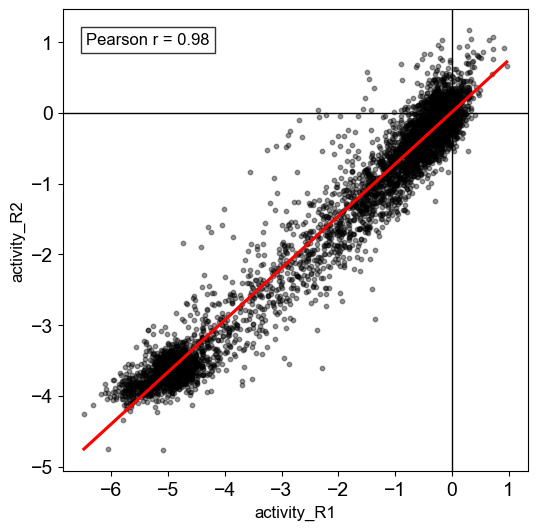

Total dots: 4632


In [17]:
data_type = 'activity'
the = 1
fig = replicate_scatter(df_Kan_input, data_type, the)
fig.savefig('./Figures/act_rep_' + str(the) + 'error.svg')
fig.savefig('./Figures/act_rep_' + str(the) + 'error.png')

plotly_fig, search_html = interactive_replicate_scatter(df_Kan_input, data_type, the)

#fig.savefig(fig_dir + 'TnsC_' + data_type + '_scatter_250104.svg', format='svg')
#print("SVG file has been saved")

Number of total points: 3305


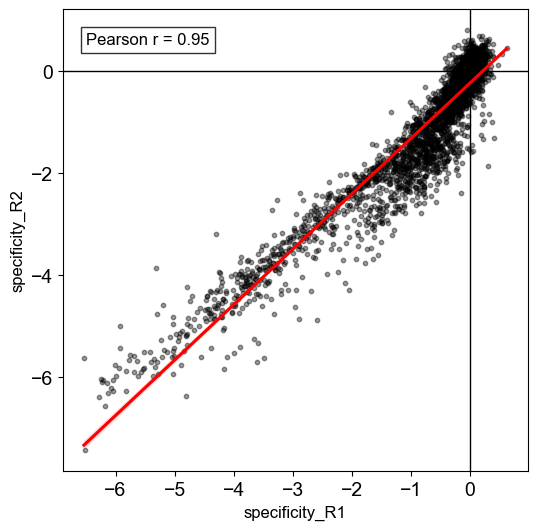

Total dots: 3305


In [18]:
data_type = 'specificity'
the = 1
fig = replicate_scatter(df_Kan_Ara, data_type, the)
fig.savefig('./Figures/spe_rep_' + str(the) + 'error.svg')
fig.savefig('./Figures/spe_rep_' + str(the) + 'error.png')

plotly_fig, search_html = interactive_replicate_scatter(df_Kan_Ara, data_type, the)

#fig.savefig(fig_dir + 'TnsC_' + data_type + 'scatter.svg', format='svg')
#print("SVG file has been saved")


list is created
iteration is done


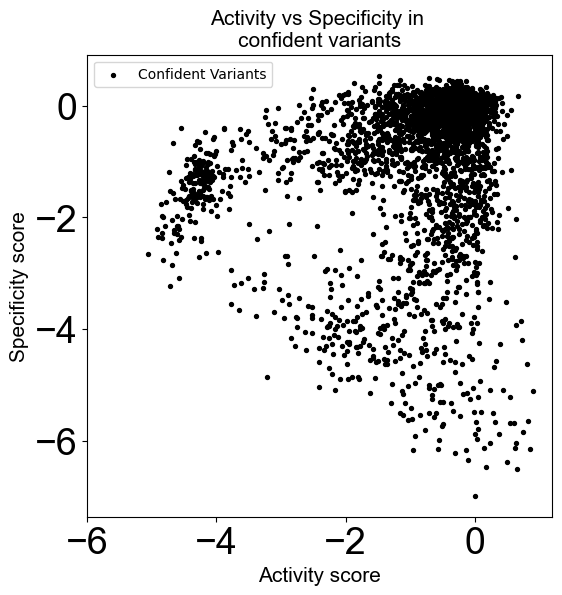

In [19]:
# Define colors for different numbers of mutations
the = 1 # Threshold for standard error
mult_variants_all = []  # List to store all multi-variant data
plt.figure(figsize=(6, 6))  # Create a new figure with specified size

filtered_Kan_input = df_Kan_input.drop_duplicates(subset=['AA_mut_list'])
filtered_Kan_Ara = df_Kan_Ara.drop_duplicates(subset=['AA_mut_list'])
# Filter the dataframe for rows with stderr less than the threshold and the specified number of mutations
indx = (filtered_Kan_input['stderr'] < the) & (filtered_Kan_input['AA_mut_list'] != "WT")
mult_variants = []  # List to store multi-variant data for the current number of mutations
print("list is created")

# Iterate over the filtered dataframe
for i in filtered_Kan_input[indx]['AA_mut_list']:
    # Check if the corresponding row in df_Kan_Ara has stderr less than the threshold
    try:
        if filtered_Kan_Ara[filtered_Kan_Ara['AA_mut_list'] == i]['stderr'].values[0] < the:
            # Extract activity and specificity values and their errors
            v_act = filtered_Kan_input[filtered_Kan_input['AA_mut_list'] == i]['activity'].values[0]
            v_spe = filtered_Kan_Ara[filtered_Kan_Ara['AA_mut_list'] == i]['specificity'].values[0]
            err_act = filtered_Kan_input[filtered_Kan_input['AA_mut_list'] == i]['stderr'].values[0]
            err_spe = filtered_Kan_Ara[filtered_Kan_Ara['AA_mut_list'] == i]['stderr'].values[0]
            # Append the data to the lists
            mult_variants.append([i, v_spe, v_act])
    except: 
        pass
print("iteration is done")

# Convert the list to a numpy array and plot the data
mult_variants = np.array(mult_variants, dtype=object)
plt.scatter(mult_variants[:, 2].astype(float), mult_variants[:, 1].astype(float),
            s=8, c='k', label='Confident Variants')

# Set plot labels and title
plt.ylabel('Specificity score', fontname='Arial',fontsize=15)
plt.xlabel('Activity score', fontname='Arial',fontsize=15)
plt.title('Activity vs Specificity in \nconfident variants', fontname='Arial',fontsize=15)
plt.xticks(np.arange(-6, 2, 2),fontname='Arial',fontsize=27)
plt.yticks(np.arange(-6, 2, 2),fontname='Arial',fontsize=27)
plt.legend()

# Step 5. Interactive Heatmap

In [20]:
AA_refSeq= "TEAQAIAKQLGGVKPDDEWLQAEIARLKGKSIVPLQQVKTLHDWLDGKRKARKSCRVVGESRTGKTVACDAYRYRHKPQQEAGRPPTVPVVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADRLKPETFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIRSLSRGLKKIDKAVLQEVAKEYK"

def plot_enrichemnt_matrix(type,df_Ara_Kan_input_sm,AA_refSeq,error,minv,maxv,size,WT_value):
    # Define the range of positions
    start_position = 2
    end_position = 276

    single_letter_amino_acids = np.array(['X', '*', 'C', 'P', 'G', #special
                                'I', 'V', 'L', 'F', 'M', 'A', 'W', #nonpolar
                                'Y', 'T', 'S', 'N', 'Q', #polar
                                'E', 'D', #negative
                                'H', 'K', 'R']) #positive

    #Mat mutations into matrix with enrichment values
    comparison_matrix=np.ones((len(single_letter_amino_acids),275))*np.nan
    stderrs=np.zeros((len(single_letter_amino_acids),275))*np.nan
    for i in df_Ara_Kan_input_sm.index:
        pos=df_Ara_Kan_input_sm['position'][i]
        mut=df_Ara_Kan_input_sm['AA_mut_list'][i]
        taa=mut[-1]
        hm_pos=np.where(single_letter_amino_acids==taa)[0][0]
        comparison_matrix[hm_pos,pos-2]=df_Ara_Kan_input_sm[type][i]
        stderrs[hm_pos,pos-2]=df_Ara_Kan_input_sm['stderr'][i]
    #Create markers for WT and no data
    markers = np.full(comparison_matrix.shape, '', dtype=object)
    for i in range(len(AA_refSeq)):
        taa=AA_refSeq[i]
        markers[np.where(single_letter_amino_acids==taa)[0][0],i] = '●'
        comparison_matrix[np.where(single_letter_amino_acids==taa)[0][0],i]=0
    comparison_matrix[:,0]
    customdata = []
    #Label hover data
    for i in range(len(single_letter_amino_acids)):
        row = []
        for j in range(start_position, end_position + 1):
            row.append(f"Position: {j}<br>Amino Acid: {single_letter_amino_acids[i]}<br>Enrichment Score: {comparison_matrix[i, j - start_position]}<br>StdErr: {stderrs[i, j - start_position]}")
        customdata.append(row)

    #Define markers for WT and No data
    markers = np.full(comparison_matrix.shape, '', dtype=object)
    markers[comparison_matrix == 0] = '●'
    print('# of positive values:',np.sum(comparison_matrix>0))

    cmap = sns.color_palette("RdBu_r", as_cmap=True)
    cmap.set_bad(color='grey')
    norm = TwoSlopeNorm(vmin=-4, vcenter=0, vmax=1)

    # Generate a Plotly-compatible colorscale
    n_bins = 256
    scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    scalar_mappable.set_array([])
    rgba_colors = scalar_mappable.to_rgba(np.linspace(norm.vmin, norm.vmax, n_bins))
    plotly_colorscale = [
        [i / (n_bins - 1), f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})"]
        for i, (r, g, b, a) in enumerate(rgba_colors)
    ]
    print("The Asymmetric colorscale is converted")
    #Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=comparison_matrix,
        x=list(range(start_position, end_position + 1)),
        y=single_letter_amino_acids,
        zmin=minv,zmax=maxv,
        colorscale=plotly_colorscale,
        customdata=customdata,
        text=markers,
        hovertemplate='%{customdata}<extra></extra>',
        colorbar=dict(title='Score',titlefont=dict(size=18), tickfont=dict(size=18)),
        texttemplate='%{text}',
        textfont=dict(color='black', size=10),
        xgap=0.5, ygap=0.5
    ))

    # Update layout to remove grid and adjust layout
    fig.update_layout(
        title=type+' TnsC',
        xaxis_title='Position',
        yaxis_title='Amino Acid',
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(tickfont=dict(size=18),showticklabels=True,ticks='outside'),
        xaxis=dict(dtick=10,tickangle=300,tickfont=dict(size=16),showticklabels=True,ticks='outside'),
        width=size[0], height=size[1],
    )
    fig.show()
    return fig, comparison_matrix, stderrs

In [21]:
#Generate a single mutation dataframe
df_Kan_input_sm=df_Kan_input[df_Kan_input['AA_mut_list']!="WT"].copy()
df_Kan_input_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_input_sm['AA_mut_list']]
df_Kan_input_sm.replace(-np.inf, -10, inplace=True)
data_type='activity'
WT_value=0
size=(4000,700)
fig, activity, stderr_act = plot_enrichemnt_matrix(data_type, df_Kan_input_sm, AA_refSeq, True, -4, 1, size, WT_value)
fig.write_html(fig_dir + 'TnsC_heatmap_'+data_type+ '_250106.html')

# of positive values: 446
The Asymmetric colorscale is converted


In [22]:
#Generate a single mutation dataframe
df_Kan_Ara_sm=df_Kan_Ara[df_Kan_Ara['AA_mut_list']!="WT"].copy()
df_Kan_Ara_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_Ara_sm['AA_mut_list']]
df_Kan_Ara_sm.replace(-np.inf, -10, inplace=True)
size=(4000,700)
data_type = 'specificity'
fig, specificity, stderr_spec = plot_enrichemnt_matrix(data_type, df_Kan_Ara_sm, AA_refSeq, True, -4, 1, size, WT_value)
fig.write_html(fig_dir + 'TnsC_heatmap_'+data_type+'_250106.html')

# of positive values: 841
The Asymmetric colorscale is converted


# Step 5-1. Non-interactive heatmap + Asymmetric colorscale (for manuscript)

In [23]:
AA_refSeq= "TEAQAIAKQLGGVKPDDEWLQAEIARLKGKSIVPLQQVKTLHDWLDGKRKARKSCRVVGESRTGKTVACDAYRYRHKPQQEAGRPPTVPVVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADRLKPETFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIRSLSRGLKKIDKAVLQEVAKEYK"

def asymmetric_seaborn_matrix(data_type, df_Ara_Kan_input_sm, AA_refSeq, error, minv, maxv, WT_value):
    start_position = 2
    end_position = 276

    single_letter_amino_acids = np.array(['R', 'K', 'H', 'D', 'E',
                                'Q', 'N', 'S', 'T', 'Y', 'W', 'A',
                                'M', 'F', 'L', 'V', 'I',
                                'G', 'P',
                                'C', '*', 'X'])

    comparison_matrix = np.full((len(single_letter_amino_acids), 275), np.nan)
    stderrs = np.full((len(single_letter_amino_acids), 275), np.nan)

    for i in df_Ara_Kan_input_sm.index:
        pos = df_Ara_Kan_input_sm['position'][i]
        mut = df_Ara_Kan_input_sm['AA_mut_list'][i]
        taa = mut[-1]
        hm_pos = np.where(single_letter_amino_acids == taa)[0][0]
        comparison_matrix[hm_pos, pos - 2] = df_Ara_Kan_input_sm[data_type][i]
        stderrs[hm_pos, pos - 2] = df_Ara_Kan_input_sm['stderr'][i]

    markers = np.full(comparison_matrix.shape, '', dtype=object)
    for i in range(len(AA_refSeq)):
        taa = AA_refSeq[i]
        aa_index = np.where(single_letter_amino_acids == taa)[0][0]
        markers[aa_index, i] = '●'
        comparison_matrix[aa_index, i] = 0
    print('# of positive values:',np.sum(comparison_matrix>=0.01))

    x_labels = list(range(start_position, end_position + 1))
    y_labels = single_letter_amino_acids
    cmap = sns.color_palette("RdBu_r", as_cmap=True)
    cmap.set_bad(color='grey')

    norm = mcolors.TwoSlopeNorm(vmin=minv, vcenter=0, vmax=maxv)
    
    fig = plt.figure(figsize=(50, 30))
    sns.heatmap(
    comparison_matrix,
    cmap=cmap,
    norm=norm,
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot=False,
    fmt=".2f",
    square=True,
    linewidths=0.4,
    linecolor='black',
    cbar_kws={'label': 'Score', 'shrink': 0.5})

    plt.yticks(rotation=0, fontsize=17,fontname='Arial')
    plt.xticks(
        ticks=[i - start_position + 0.5 for i in range(10, end_position + 1, 10)],
        labels=range(10, end_position + 1, 10),
        fontsize=40, fontname='Arial'
    )
    num_rows, num_cols = comparison_matrix.shape
    for i in range(num_rows):
        for j in range(num_cols):
            if comparison_matrix[i, j] == 0:
                plt.plot(j + 0.5, i + 0.5, 'k.', markersize=10)

    plt.tight_layout()
    plt.show()

    return fig, comparison_matrix, stderrs


# of positive values: 417


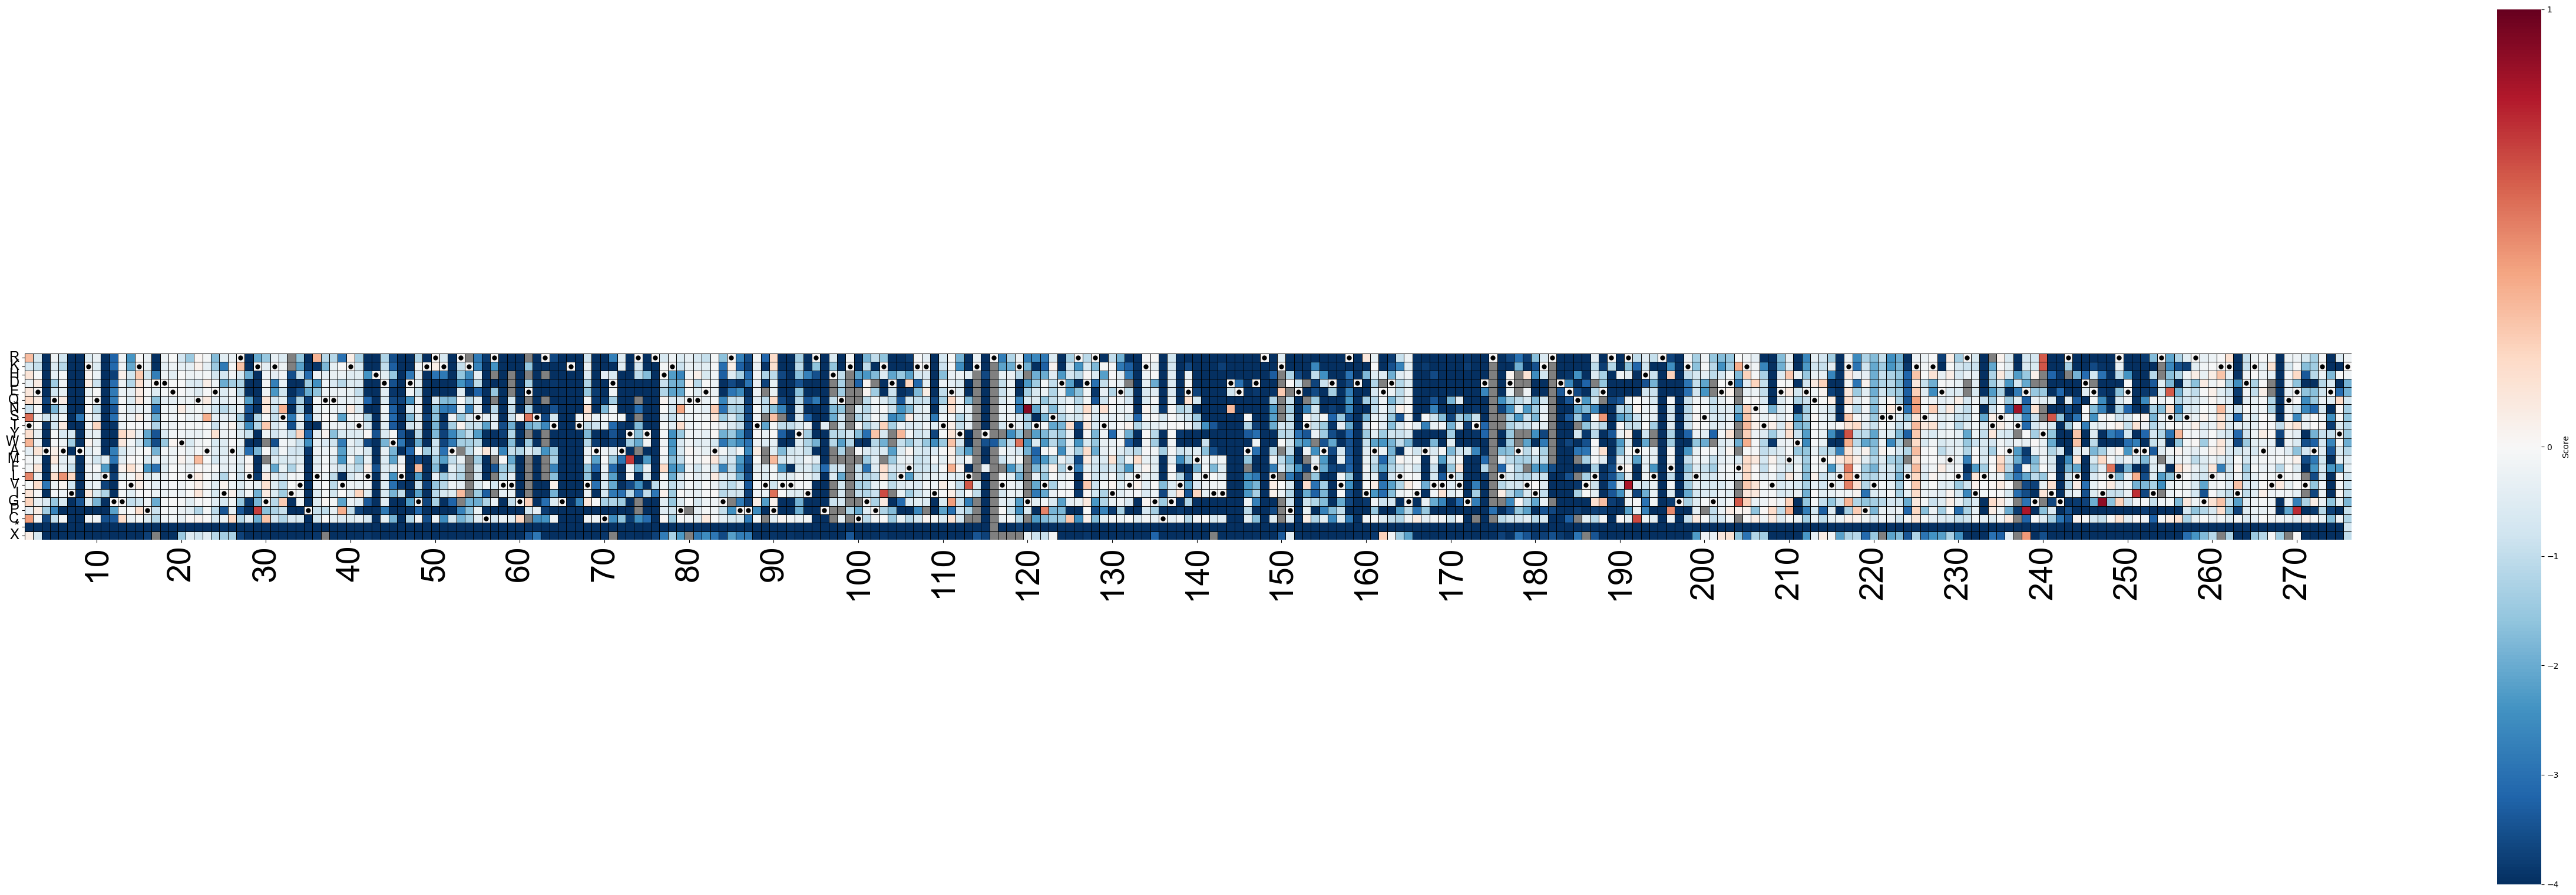

In [24]:
#Activity Heatmap
maxcolor = 1
mincolor = -4
df_Kan_input_sm=df_Kan_input[df_Kan_input['AA_mut_list']!="WT"].copy()
df_Kan_input_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_input_sm['AA_mut_list']]
df_Kan_input_sm.replace(-np.inf, -10, inplace=True)
data_type = 'activity'
WT_value=0
fig, activity, stderr_act = asymmetric_seaborn_matrix(data_type, df_Kan_input_sm, AA_refSeq, True, mincolor, maxcolor, WT_value)
fig.savefig(fig_dir + 'TnsC_' + data_type + '(1-4)_250106.svg', format='svg')
#print('File has been saved')

# of positive values: 802


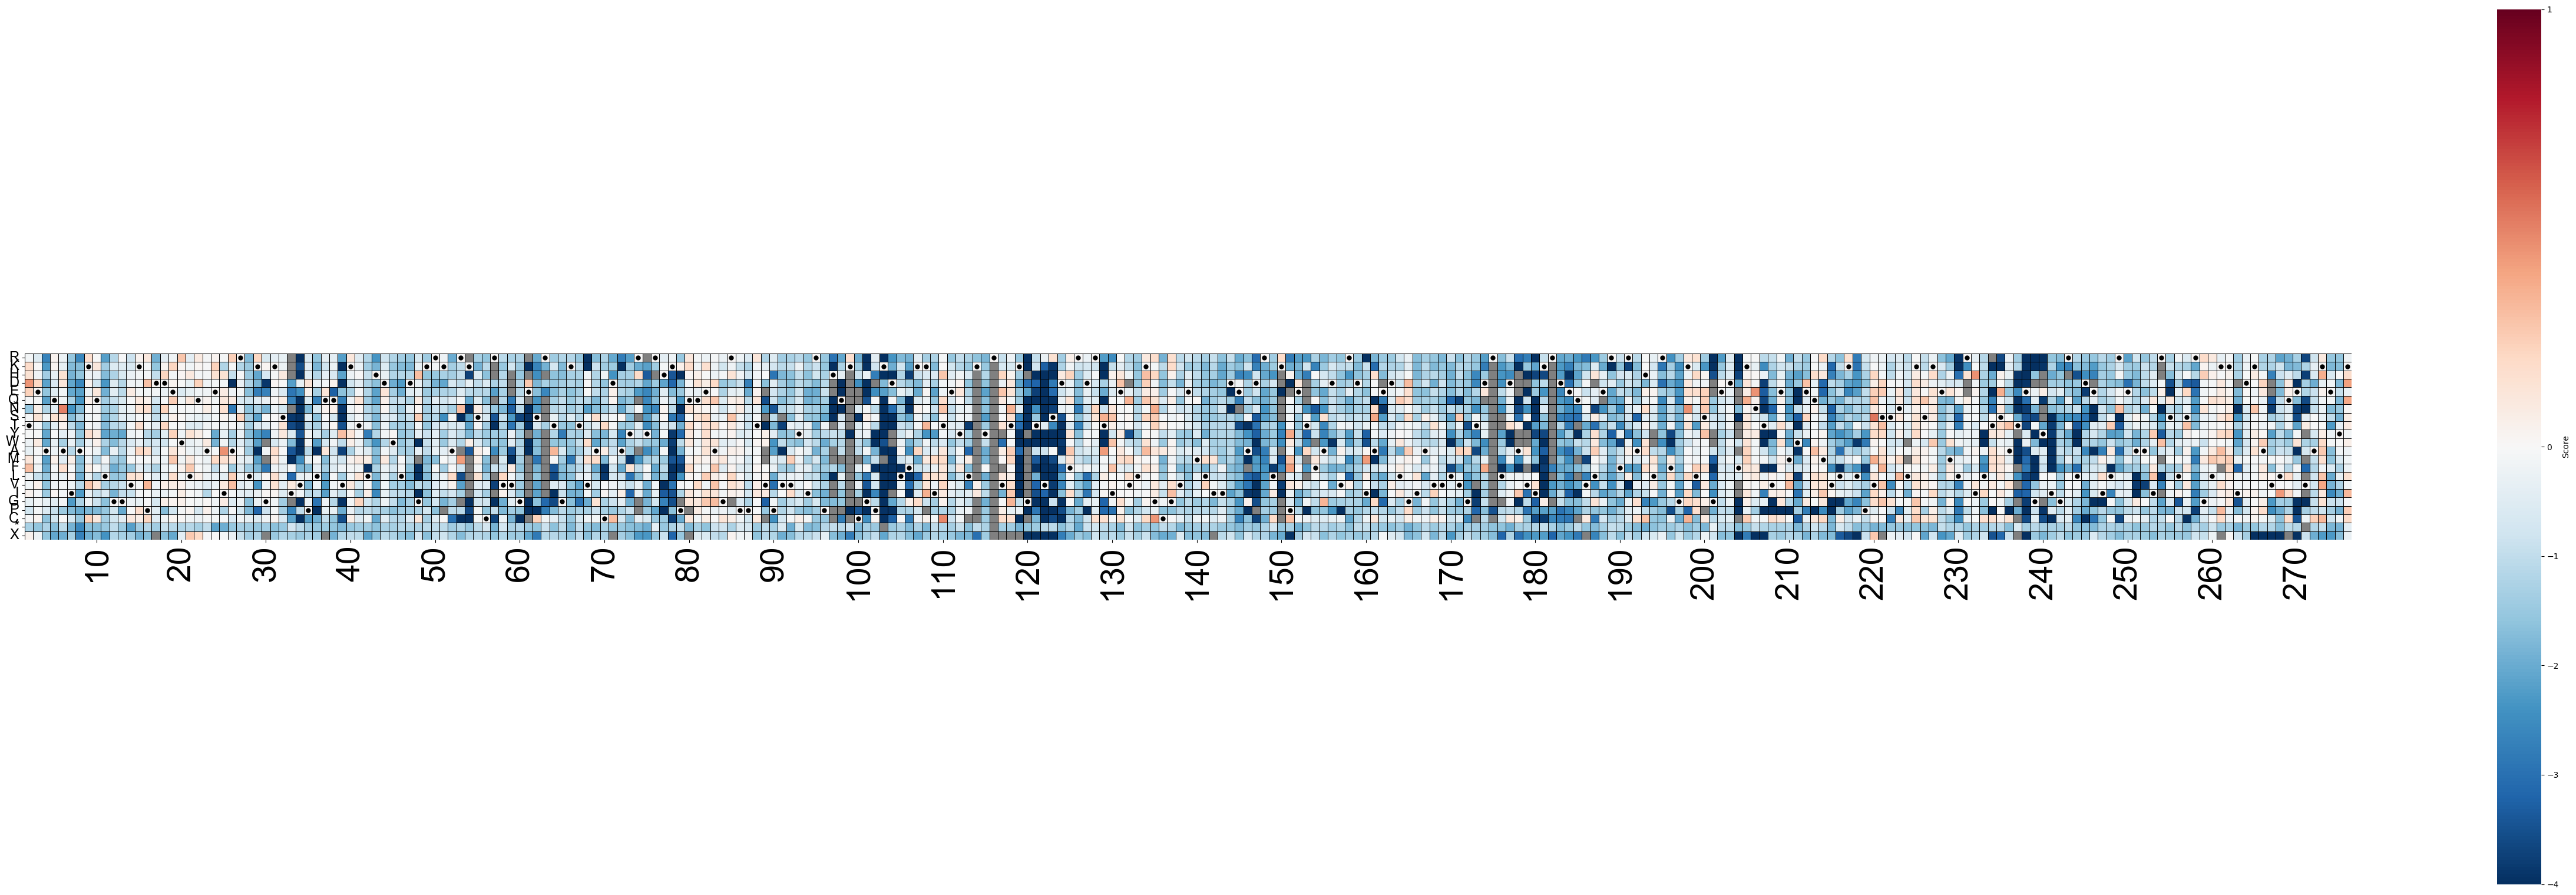

File has been saved


In [25]:
#Specificity Heatmap
maxcolor = 1
mincolor = -4
df_Kan_Ara_sm=df_Kan_Ara[df_Kan_Ara['AA_mut_list']!="WT"].copy()
df_Kan_Ara_sm['position'] = [int(''.join(list(i[1:-1]))) for i in df_Kan_Ara_sm['AA_mut_list']]
df_Kan_Ara_sm.replace(-np.inf, -10, inplace=True)
data_type = 'specificity'
fig, specificity, stderr_spec = asymmetric_seaborn_matrix(data_type, df_Kan_Ara_sm, AA_refSeq, True, mincolor, maxcolor, WT_value)
fig.savefig(fig_dir + 'TnsC_' + data_type + '(1-4)_250106.svg', format='svg')
print('File has been saved')

# Step 7. Frustration analysis

In [18]:
import frustratometer
import matplotlib.pylab as plt
import numpy as np
import mdtraj as md
from scipy.stats import mannwhitneyu

In [30]:
missing_res=[  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 276]
dict_res={}
c=0
for i in range(1,277):
    if not i in missing_res:
        dict_res[i]=c
        c=c+1
print(dict_res)

{19: 0, 20: 1, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 28: 9, 29: 10, 30: 11, 31: 12, 32: 13, 33: 14, 34: 15, 35: 16, 36: 17, 37: 18, 38: 19, 39: 20, 40: 21, 41: 22, 42: 23, 43: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29, 49: 30, 50: 31, 51: 32, 52: 33, 53: 34, 54: 35, 55: 36, 56: 37, 57: 38, 58: 39, 59: 40, 60: 41, 61: 42, 62: 43, 63: 44, 64: 45, 65: 46, 66: 47, 67: 48, 68: 49, 69: 50, 70: 51, 71: 52, 72: 53, 73: 54, 74: 55, 75: 56, 76: 57, 77: 58, 78: 59, 79: 60, 80: 61, 81: 62, 82: 63, 83: 64, 84: 65, 85: 66, 86: 67, 87: 68, 88: 69, 89: 70, 90: 71, 91: 72, 92: 73, 93: 74, 94: 75, 95: 76, 96: 77, 97: 78, 98: 79, 99: 80, 100: 81, 101: 82, 102: 83, 103: 84, 104: 85, 105: 86, 106: 87, 107: 88, 108: 89, 109: 90, 110: 91, 111: 92, 112: 93, 113: 94, 114: 95, 115: 96, 116: 97, 117: 98, 118: 99, 119: 100, 120: 101, 121: 102, 122: 103, 123: 104, 124: 105, 125: 106, 126: 107, 127: 108, 128: 109, 129: 110, 130: 111, 131: 112, 132: 113, 133: 114, 134: 115, 135: 116, 136: 117, 137: 118, 

In [31]:
# Define the path to your PDB file
pdb_path = '../8rdu/8rdu_TnsC(K).pdb'
AA=list('-ACDEFGHIKLMNPQRSTVWY')
structure = frustratometer.Structure.full_pdb(pdb_path)
print(len(structure.sequence),structure.sequence)
## Single residue frustration with electrostatics
AWSEM_model = frustratometer.AWSEM(structure,distance_cutoff_contact=9.5) 
native_frust=AWSEM_model.frustration(kind='singleresidue')

@> 2066 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2066 atoms and 1 coordinate set(s) were parsed in 0.01s.


257 EWLQAEIARLKGKSIVPLQQVKTLHDWLDGKRKARKSCRVVGESRTGKTVACDAYRYRHKPQQEAGRPPTVPVVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADRLKPETFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIRSLSRGLKKIDKAVLQEVAKEY


In [32]:
df_tmp=df_Kan_input.drop_duplicates(subset=['AA_mut_list'])
indx=(df_tmp['stderr']<1)
mult_variants=[]
for i in df_tmp[indx]['AA_mut_list']:
    try:
        v_act=df_tmp[df_tmp['AA_mut_list']==i]['activity'].values[0]
        mult_variants.append([i,v_act])
    except:
        pass
mult_variants=np.array(mult_variants,dtype=object)
top_p=mult_variants[mult_variants[:,1]>0.5,0]
N=len(top_p)
bottom_p=[i[0] for i in mult_variants[np.argsort(mult_variants[:,1])][:N]]

In [33]:
mult_variants[np.argsort(mult_variants[:,1])]

array([['V271Y', -5.350787616673853],
       ['E145C', -5.054642995275909],
       ['R195Y', -4.930848916068464],
       ...,
       ['T237N', 0.8459381454779836],
       ['I247G', 0.8951692265534213],
       ['G120N', 0.9152704772755116]], dtype=object)

In [34]:
mult_variants[mult_variants[:,1]>0.5]

array([['A251I', 0.7336269667025546],
       ['E270P', 0.7423106031600358],
       ['R191V', 0.8098916997135662],
       ['A192C', 0.6592211897049132],
       ['I241S', 0.6311400976251372],
       ['L113V', 0.6211160466160848],
       ['F204G', 0.624714904593135],
       ['E238P', 0.8172311934186641],
       ['P90I', 0.5506931724778282],
       ['I247G', 0.8951692265534213],
       ['K103I', 0.648956335821713],
       ['L248F', 0.5411599239981928],
       ['K217V', 0.500837618065822],
       ['K29P', 0.6950587281800834],
       ['E61S', 0.5340587342565808],
       ['K217F', 0.5161589088322317],
       ['S255E', 0.6104732939162206],
       ['T237N', 0.8459381454779836],
       ['G120N', 0.9152704772755116],
       ['Y73M', 0.7083734953346242],
       ['K119W', 0.5416540640793506],
       ['Y240R', 0.6108682103644747],
       ['K217Y', 0.6349212479038218],
       ['Y240K', 0.6289135501002644],
       ['T2S', 0.555998390651363]], dtype=object)

A251I
REAAI
REIAI
E270P
LQEVA
LQPVA
R191V
RFRAH
RFVAH
A192C
FRAHL
FRCHL
I241S
GYIGR
GYSGR
L113V
EYLKY
EYVKY
F204G
EDFKN
EDGKN
E238P
ATEGY
ATPGY
P90I
TVPVV
TVIVV
I247G
DEILR
DEGLR
K103I
GPKDL
GPIDL
L248F
EILRE
EIFRE
K217V
VLKLP
VLVLP
K29P
RLKGK
RLPGK
E61S
VGESR
VGSSR
K217F
VLKLP
VLFLP
S255E
IRSLS
IRELS
T237N
SATEG
SANEG
G120N
TKGTV
TKNTV
Y73M
DAYRY
DAMRY
K119W
VTKGT
VTWGT
Y240R
EGYIG
EGRIG
K217Y
VLKLP
VLYLP
Y240K
EGYIG
EGKIG


(-7.0, 7.0)

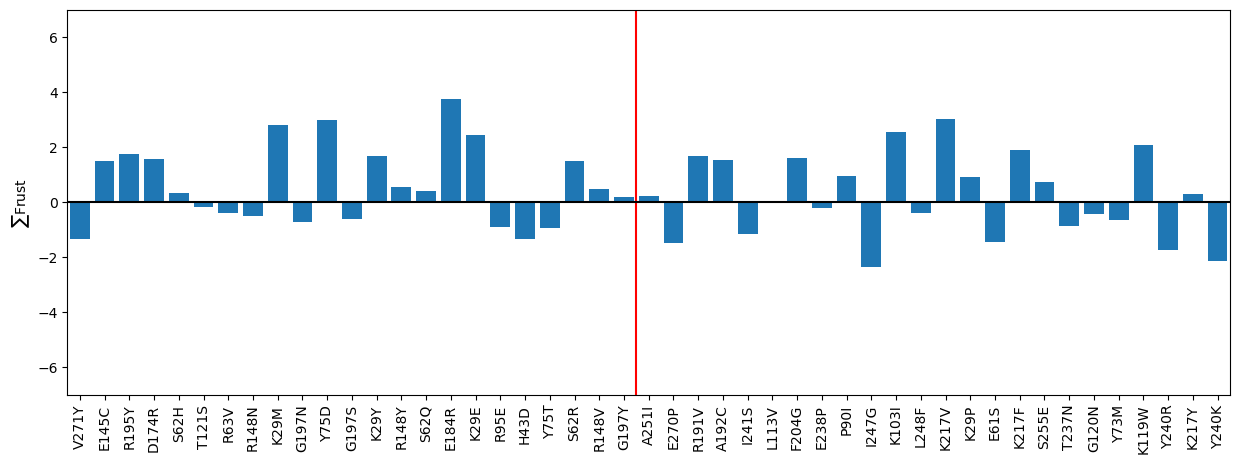

In [35]:
mut_list_b=[]
diff_frust_b=[]
for mutation in bottom_p:
    native_sequence=structure.sequence
    ind_mut=mutation.split('+')
    newseq=native_sequence
    if int(ind_mut[0][1:-1]) in dict_res.keys():
        mut_list_b.append(mutation)
        for mut in ind_mut:
            gm = list(mut)
            gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
            mut_position=dict_res[gm[1]]
            mut_aa=gm[2]
            newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
        frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
        diff_frust_b.append(np.sum(frustration_values-native_frust))

mut_list_g=[]
diff_frust_g=[]
for mutation in top_p:
    native_sequence=structure.sequence
    ind_mut=mutation.split('+')
    newseq=native_sequence
    if int(ind_mut[0][1:-1]) in dict_res.keys():
        mut_list_g.append(mutation)
        for mut in ind_mut:
            gm = list(mut)
            gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
            mut_position=dict_res[gm[1]]
            mut_aa=gm[2]
            print('='*40,'\n'+mut)
            print(newseq[mut_position-2:mut_position+3])
            newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
            print(newseq[mut_position-2:mut_position+3])
        frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
        diff_frust_g.append(np.sum(frustration_values-native_frust))

mut_list=np.concatenate([mut_list_b,mut_list_g])
diff_frust=np.concatenate([diff_frust_b,diff_frust_g])
plt.figure(figsize=(15,5))
plt.bar(mut_list,diff_frust)
plt.xticks(rotation=90)
plt.axvline(len(mut_list_b)-0.5,color='red')
plt.axhline(0,color='k')
plt.ylabel(r'$\sum \text{Frust}$')
plt.xlim([-0.5,len(mut_list)-0.5])
plt.ylim([-7,7])

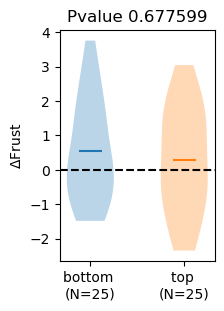

In [26]:
plt.figure(figsize=(2,3))
p=plt.violinplot([diff_frust[:N]],positions=[0],showmeans=True, showextrema=False)
p=plt.violinplot([diff_frust[N:]],positions=[1],showmeans=True, showextrema=False)
plt.xticks([0,1],['bottom \n(N='+str(N)+')','top \n(N='+str(N)+')'])
plt.ylabel(r'$\Delta \text{Frust}$')
#plt.legend(['high\nenrichment\nn='+str(N),'low\nenrichment\nn='+str(N)])
plt.axhline(0,color='k',linestyle='--')
plt.title('Pvalue '+str(np.round(mannwhitneyu(diff_frust[:N],diff_frust[N:])[1],6)))
plt.savefig('Figures/frust_violin_plot_tnsC.svg')

# Step 8. ThermoMPNN

In [27]:
import matplotlib.pylab as plt
import numpy as np
import mdtraj as md
from scipy.stats import mannwhitneyu
import pandas as pd

In [28]:
thermo = pd.read_csv('../ThermoMPNN/8rdu_TnsC(K).csv')

(-7.0, 7.0)

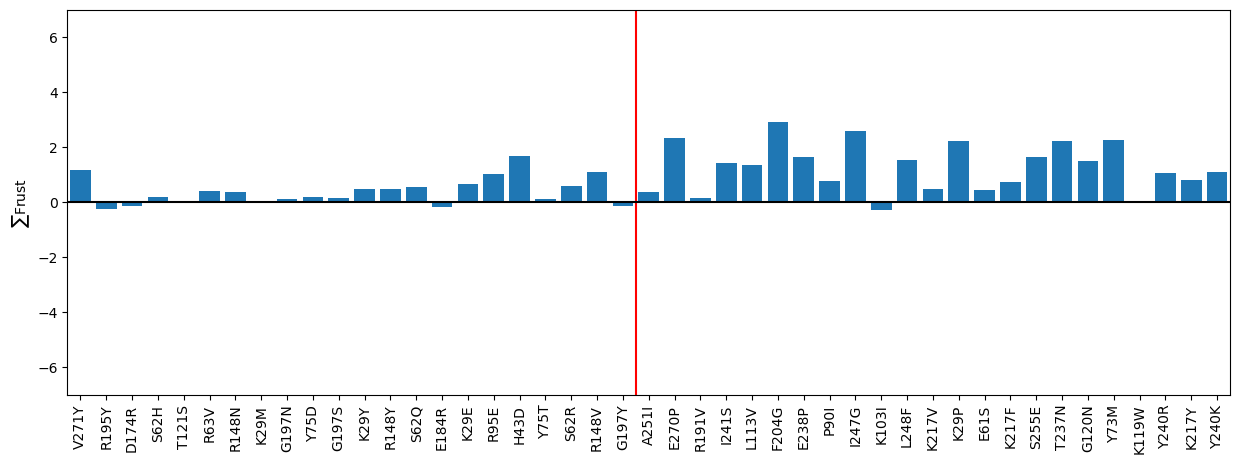

In [37]:
mut_list_b=bottom_p
diff_frust_b=[]
found_mut_b=[]
for mutation in mut_list_b:
    if not "*" in mutation and not "C"==mutation[-1] and int(mutation[1:-1]) in dict_res.keys(): 
        gm = list(mutation)
        gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
        mut_position=dict_res[gm[1]]
        mut_trans = gm[0]+str(mut_position)+gm[-1]
        thermo[thermo['Mutation']==mut_trans]['ddG (kcal/mol)'].values[0]
        diff_frust_b.append(thermo[thermo['Mutation']==mut_trans]['ddG (kcal/mol)'].values[0])
        found_mut_b.append(mutation)

mut_list_g=top_p
diff_frust_g=[]
found_mut_g=[]
for mutation in mut_list_g:
    if not "*" in mutation and not "C"==mutation[-1] and int(mutation[1:-1]) in dict_res.keys():
        gm = list(mutation)
        gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
        mut_position=dict_res[gm[1]]
        mut_trans = gm[0]+str(mut_position)+gm[-1]
        thermo[thermo['Mutation']==mut_trans]['ddG (kcal/mol)'].values[0]
        diff_frust_g.append(thermo[thermo['Mutation']==mut_trans]['ddG (kcal/mol)'].values[0])
        found_mut_g.append(mutation)

mut_list=np.concatenate([found_mut_b,found_mut_g])
diff_frust=np.concatenate([diff_frust_b,diff_frust_g])
plt.figure(figsize=(15,5))
plt.bar(mut_list,diff_frust)
plt.xticks(rotation=90)
plt.axvline(len(found_mut_b)-0.5,color='red')
plt.axhline(0,color='k')
plt.ylabel(r'$\sum \text{Frust}$')
plt.xlim([-0.5,len(mut_list)-0.5])
plt.ylim([-7,7])

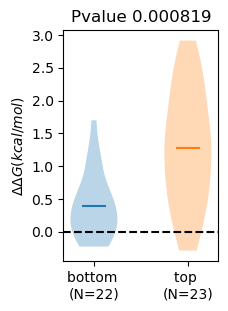

In [39]:
plt.figure(figsize=(2,3))
p=plt.violinplot([diff_frust[:len(found_mut_b)]],positions=[0],showmeans=True, showextrema=False)
p=plt.violinplot([diff_frust[len(found_mut_b):]],positions=[1],showmeans=True, showextrema=False)
plt.xticks([0,1],['bottom \n(N='+str(len(found_mut_b))+')','top \n(N='+str(len(diff_frust_g))+')'])
plt.ylabel(r'$\Delta \Delta G (kcal/mol)$')
plt.axhline(0,color='k',linestyle='--')
plt.title('Pvalue '+str(np.round(mannwhitneyu(diff_frust[:N],diff_frust[N:])[1],6)))
plt.savefig('Figures/ThermoMPNN_violin_plot.svg')

In [42]:
bottom_p

['V271Y',
 'E145C',
 'R195Y',
 'D174R',
 'S62H',
 'T121S',
 'R63V',
 'R148N',
 'K9P',
 'K29M',
 'G197N',
 'Y75D',
 'G197S',
 'K29Y',
 'R148Y',
 'S62Q',
 'E184R',
 'K29E',
 'K9X',
 'R95E',
 'H43D',
 'Y75T',
 'S62R',
 'R148V',
 'G197Y']

In [41]:
mut_list

array(['V271Y', 'R195Y', 'D174R', 'S62H', 'T121S', 'R63V', 'R148N',
       'K29M', 'G197N', 'Y75D', 'G197S', 'K29Y', 'R148Y', 'S62Q', 'E184R',
       'K29E', 'R95E', 'H43D', 'Y75T', 'S62R', 'R148V', 'G197Y', 'A251I',
       'E270P', 'R191V', 'I241S', 'L113V', 'F204G', 'E238P', 'P90I',
       'I247G', 'K103I', 'L248F', 'K217V', 'K29P', 'E61S', 'K217F',
       'S255E', 'T237N', 'G120N', 'Y73M', 'K119W', 'Y240R', 'K217Y',
       'Y240K'], dtype='<U5')

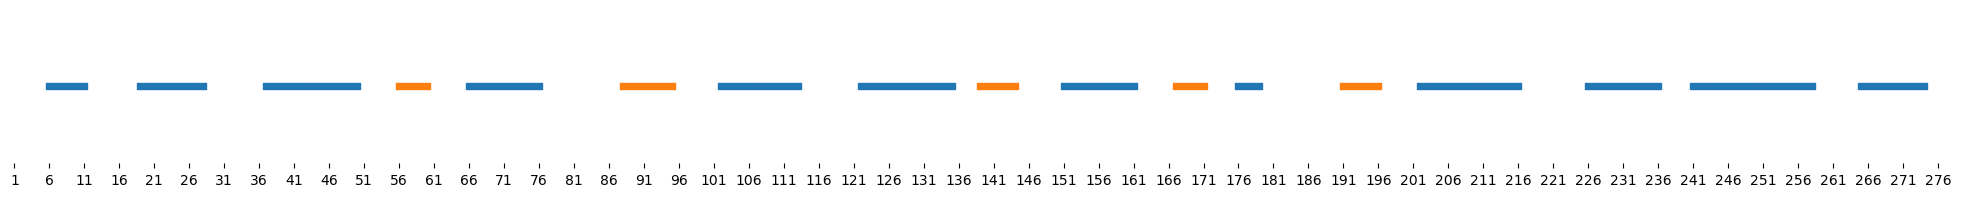

In [ ]:
import numpy as np
import matplotlib.pylab as plt
jnet="-,-,-,-,-,H,H,H,H,H,H,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,E,E,E,E,E,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,-,-,-,E,E,E,E,E,E,E,E,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,E,E,E,E,E,E,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,E,E,E,E,E,-,-,-,-,H,H,H,H,-,-,-,-,-,-,-,-,-,-,-,E,E,E,E,E,E,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,-,-,"
jnet=jnet.split(',')
basen=np.zeros(len(jnet))
hel=np.where([i=='H' for i in jnet])[0]+1
bet=np.where([i=='E' for i in jnet])[0]+1
plt.figure(figsize=(25,2))
plt.scatter(hel,np.ones_like(hel),marker='s',s=15)
plt.scatter(bet,np.ones_like(bet),marker='s',s=15)
plt.xlim([1-0.5,len(jnet)+0.5])
plt.xticks([i for i in range(1,len(jnet),5)])
plt.yticks([])
plt.box(False)
plt.savefig('secondary_prediction.svg')

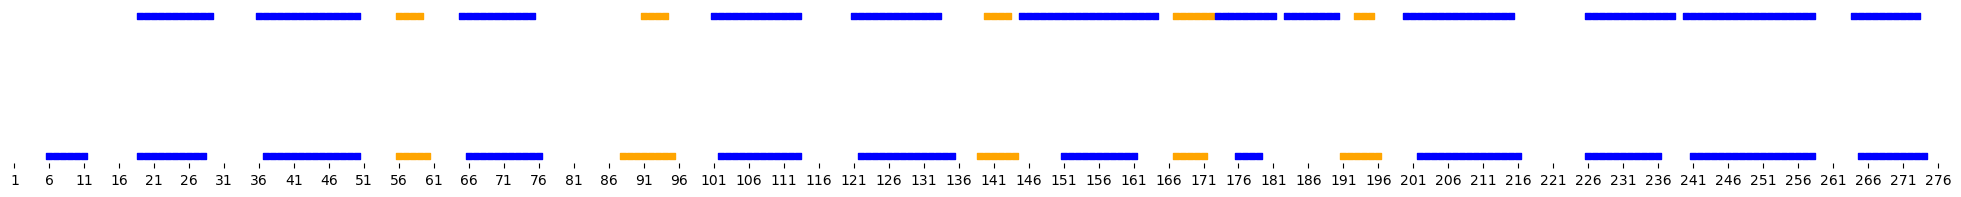

In [ ]:
pymol=[[19, 'H'],[20, 'H'],[21, 'H'],[22, 'H'],[23, 'H'],[24, 'H'],[25, 'H'],[26, 'H'],[27, 'H'],[28, 'H'],[29, 'H'],[36, 'H'],[37, 'H'],[38, 'H'],[39, 'H'],[40, 'H'],[41, 'H'],[42, 'H'],[43, 'H'],[44, 'H'],[45, 'H'],[46, 'H'],[47, 'H'],[48, 'H'],[49, 'H'],[50, 'H'],[56, 'S'],[57, 'S'],[58, 'S'],[59, 'S'],[65, 'H'],[66, 'H'],[67, 'H'],[68, 'H'],[69, 'H'],[70, 'H'],[71, 'H'],[72, 'H'],[73, 'H'],[74, 'H'],[75, 'H'],[91, 'S'],[92, 'S'],[93, 'S'],[94, 'S'],[101, 'H'],[102, 'H'],[103, 'H'],[104, 'H'],[105, 'H'],[106, 'H'],[107, 'H'],[108, 'H'],[109, 'H'],[110, 'H'],[111, 'H'],[112, 'H'],[113, 'H'],[121, 'H'],[122, 'H'],[123, 'H'],[124, 'H'],[125, 'H'],[126, 'H'],[127, 'H'],[128, 'H'],[129, 'H'],[130, 'H'],[131, 'H'],[132, 'H'],[133, 'H'],[140, 'S'],[141, 'S'],[142, 'S'],[143, 'S'],[145, 'H'],[146, 'H'],[147, 'H'],[148, 'H'],[149, 'H'],[150, 'H'],[151, 'H'],[152, 'H'],[153, 'H'],[154, 'H'],[155, 'H'],[156, 'H'],[157, 'H'],[158, 'H'],[159, 'H'],[160, 'H'],[161, 'H'],[162, 'H'],[163, 'H'],[164, 'H'],[167, 'S'],[168, 'S'],[169, 'S'],[170, 'S'],[171, 'S'],[172, 'S'],[173, 'H'],[174, 'H'],[175, 'H'],[176, 'H'],[177, 'H'],[178, 'H'],[179, 'H'],[180, 'H'],[181, 'H'],[183, 'H'],[184, 'H'],[185, 'H'],[186, 'H'],[187, 'H'],[188, 'H'],[189, 'H'],[190, 'H'],[193, 'S'],[194, 'S'],[195, 'S'],[200, 'H'],[201, 'H'],[202, 'H'],[203, 'H'],[204, 'H'],[205, 'H'],[206, 'H'],[207, 'H'],[208, 'H'],[209, 'H'],[210, 'H'],[211, 'H'],[212, 'H'],[213, 'H'],[214, 'H'],[215, 'H'],[226, 'H'],[227, 'H'],[228, 'H'],[229, 'H'],[230, 'H'],[231, 'H'],[232, 'H'],[233, 'H'],[234, 'H'],[235, 'H'],[236, 'H'],[237, 'H'],[238, 'H'],[240, 'H'],[241, 'H'],[242, 'H'],[243, 'H'],[244, 'H'],[245, 'H'],[246, 'H'],[247, 'H'],[248, 'H'],[249, 'H'],[250, 'H'],[251, 'H'],[252, 'H'],[253, 'H'],[254, 'H'],[255, 'H'],[256, 'H'],[257, 'H'],[258, 'H'],[264, 'H'],[265, 'H'],[266, 'H'],[267, 'H'],[268, 'H'],[269, 'H'],[270, 'H'],[271, 'H'],[272, 'H'],[273, 'H']]

plt.figure(figsize=(25,2))
plt.scatter(hel,np.ones_like(hel),marker='s',s=15,c='b')
plt.scatter(bet,np.ones_like(bet),marker='s',s=15,c='orange')
plt.xlim([1-0.5,len(jnet)+0.5])
plt.xticks([i for i in range(1,len(jnet),5)])
plt.yticks([])
plt.box(False)

for i in range(len(pymol)):
    if pymol[i][1]=='H':
        plt.scatter([pymol[i][0]],[1.5],c='b',marker='s',s=15)
    if pymol[i][1]=='S':
        plt.scatter([pymol[i][0]],[1.5],c='orange',marker='s',s=15)
plt.savefig('secondary_prediction_and_real_secondary_struc.svg')

In [ ]:
df_Kan_input[df_Kan_input['AA_mut_list']=='W10K']

Unnamed: 0  index AA_mut_list NT_mut_list  AA_mut_#  NT_mut_#  \
1117        1117   1121        W10K   T26A+G27A         1         2   

                                                 AA_seq  \
1117  IEAPDVKPKLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIG...   

                                                 NT_seq  reads_AA_input_R1  \
1117  ATAGAAGCACCAGATGTTAAACCTAAGCTATTCTTGATTAAACCCT...                289   

      reads_NT_input_R1  ...  freq_NT_Kan_R2  enrich_Kan_R2  stderr_Kan_R2  \
1117                216  ...             0.0      -8.078646         1.4178   

      activity_R1  stderr_R1  activity_R2  stderr_R2  activity    stderr  \
1117    -7.615984   1.415847    -8.078646     1.4178 -7.846997  0.053242   

      pvalues  
1117  0.01457  

[1 rows x 35 columns]

In [26]:
import frustratometer
import matplotlib.pylab as plt
import numpy as np
import mdtraj as md
from scipy.stats import mannwhitneyu

In [27]:
missing_res=[  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 276]
dict_res={}
c=0
for i in range(1,277):
    if not i in missing_res:
        dict_res[i]=c
        c=c+1
print(dict_res)

{19: 0, 20: 1, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 28: 9, 29: 10, 30: 11, 31: 12, 32: 13, 33: 14, 34: 15, 35: 16, 36: 17, 37: 18, 38: 19, 39: 20, 40: 21, 41: 22, 42: 23, 43: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29, 49: 30, 50: 31, 51: 32, 52: 33, 53: 34, 54: 35, 55: 36, 56: 37, 57: 38, 58: 39, 59: 40, 60: 41, 61: 42, 62: 43, 63: 44, 64: 45, 65: 46, 66: 47, 67: 48, 68: 49, 69: 50, 70: 51, 71: 52, 72: 53, 73: 54, 74: 55, 75: 56, 76: 57, 77: 58, 78: 59, 79: 60, 80: 61, 81: 62, 82: 63, 83: 64, 84: 65, 85: 66, 86: 67, 87: 68, 88: 69, 89: 70, 90: 71, 91: 72, 92: 73, 93: 74, 94: 75, 95: 76, 96: 77, 97: 78, 98: 79, 99: 80, 100: 81, 101: 82, 102: 83, 103: 84, 104: 85, 105: 86, 106: 87, 107: 88, 108: 89, 109: 90, 110: 91, 111: 92, 112: 93, 113: 94, 114: 95, 115: 96, 116: 97, 117: 98, 118: 99, 119: 100, 120: 101, 121: 102, 122: 103, 123: 104, 124: 105, 125: 106, 126: 107, 127: 108, 128: 109, 129: 110, 130: 111, 131: 112, 132: 113, 133: 114, 134: 115, 135: 116, 136: 117, 137: 118, 

In [28]:
# Define the path to your PDB file
pdb_path = '../8rdu/8rdu_TnsC(K_others).pdb'
AA=list('-ACDEFGHIKLMNPQRSTVWY')
structure = frustratometer.Structure.full_pdb(pdb_path)
print(len(structure.sequence),structure.sequence)
## Single residue frustration with electrostatics
AWSEM_model = frustratometer.AWSEM(structure,distance_cutoff_contact=9.5) 
native_frust=AWSEM_model.frustration(kind='singleresidue')

@> 5278 atoms and 1 coordinate set(s) were parsed in 0.04s.
/Users/edoderor/anaconda3/envs/pbase/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning:

Ignoring unrecognized record 'TER ' at line 2067

/Users/edoderor/anaconda3/envs/pbase/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning:


@> 5278 atoms and 1 coordinate set(s) were parsed in 0.02s.


647 EWLQAEIARLKGKSIVPLQQVKTLHDWLDGKRKARKSCRVVGESRTGKTVACDAYRYRHKPQQEAGRPPTVPVVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADRLKPETFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIRSLSRGLKKIDKAVLQEVAKEYVGETDRLDAVIKRDEQVLERFRAHLRGKLSGEAEIARLKGKSIVPLVVGESRGKTVACDAYRYRVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEDRLKPETFAVLVGTDRLDAVIKRDEQVLERFGLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIKKIDKAVLQVAKYKTLHDWLDGKRKARKSCRVVYRYRHKPQPTVPVVYIRPHQKCPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADKPEFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRYRHKPQQERPPTVPVVKDFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEL


In [29]:
df_tmp=df_Kan_input.drop_duplicates(subset=['AA_mut_list'])
indx=(df_tmp['stderr']<1)
mult_variants=[]
for i in df_tmp[indx]['AA_mut_list']:
    try:
        v_act=df_tmp[df_tmp['AA_mut_list']==i]['activity'].values[0]
        mult_variants.append([i,v_act])
    except:
        pass
mult_variants=np.array(mult_variants,dtype=object)
top_p=mult_variants[mult_variants[:,1]>0.5,0]
N=len(top_p)
bottom_p=[i[0] for i in mult_variants[np.argsort(mult_variants[:,1])][:N]]

In [30]:
mult_variants[np.argsort(mult_variants[:,1])]

array([['V271Y', -5.350787616673853],
       ['E145C', -5.054642995275909],
       ['R195Y', -4.930848916068464],
       ...,
       ['T237N', 0.8459381454779836],
       ['I247G', 0.8951692265534213],
       ['G120N', 0.9152704772755116]], dtype=object)

In [31]:
mult_variants[mult_variants[:,1]>0.5]

array([['A251I', 0.7336269667025546],
       ['E270P', 0.7423106031600358],
       ['R191V', 0.8098916997135662],
       ['A192C', 0.6592211897049132],
       ['I241S', 0.6311400976251372],
       ['L113V', 0.6211160466160848],
       ['F204G', 0.624714904593135],
       ['E238P', 0.8172311934186641],
       ['P90I', 0.5506931724778282],
       ['I247G', 0.8951692265534213],
       ['K103I', 0.648956335821713],
       ['L248F', 0.5411599239981928],
       ['K217V', 0.500837618065822],
       ['K29P', 0.6950587281800834],
       ['E61S', 0.5340587342565808],
       ['K217F', 0.5161589088322317],
       ['S255E', 0.6104732939162206],
       ['T237N', 0.8459381454779836],
       ['G120N', 0.9152704772755116],
       ['Y73M', 0.7083734953346242],
       ['K119W', 0.5416540640793506],
       ['Y240R', 0.6108682103644747],
       ['K217Y', 0.6349212479038218],
       ['Y240K', 0.6289135501002644],
       ['T2S', 0.555998390651363]], dtype=object)

A251I
REAAI
REIAI
E270P
LQEVA
LQPVA
R191V
RFRAH
RFVAH
A192C
FRAHL
FRCHL
I241S
GYIGR
GYSGR
L113V
EYLKY
EYVKY
F204G
EDFKN
EDGKN
E238P
ATEGY
ATPGY
P90I
TVPVV
TVIVV
I247G
DEILR
DEGLR
K103I
GPKDL
GPIDL
L248F
EILRE
EIFRE
K217V
VLKLP
VLVLP
K29P
RLKGK
RLPGK
E61S
VGESR
VGSSR
K217F
VLKLP
VLFLP
S255E
IRSLS
IRELS
T237N
SATEG
SANEG
G120N
TKGTV
TKNTV
Y73M
DAYRY
DAMRY
K119W
VTKGT
VTWGT
Y240R
EGYIG
EGRIG
K217Y
VLKLP
VLYLP
Y240K
EGYIG
EGKIG


(-7.0, 7.0)

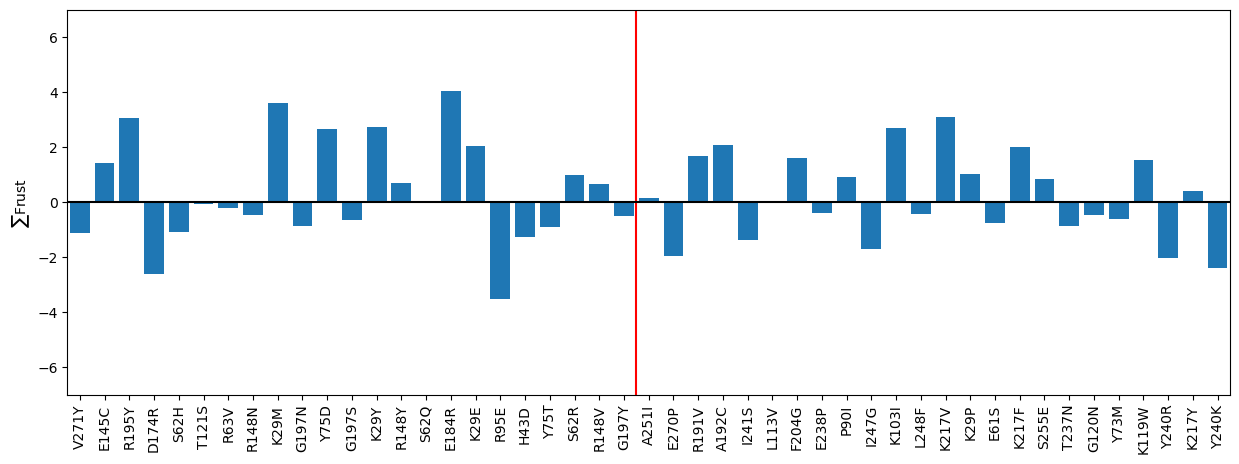

In [32]:
mut_list_b=[]
diff_frust_b=[]
for mutation in bottom_p:
    native_sequence=structure.sequence
    ind_mut=mutation.split('+')
    newseq=native_sequence
    if int(ind_mut[0][1:-1]) in dict_res.keys():
        mut_list_b.append(mutation)
        for mut in ind_mut:
            gm = list(mut)
            gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
            mut_position=dict_res[gm[1]]
            mut_aa=gm[2]
            newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
        frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
        diff_frust_b.append(np.sum(frustration_values-native_frust))

mut_list_g=[]
diff_frust_g=[]
for mutation in top_p:
    native_sequence=structure.sequence
    ind_mut=mutation.split('+')
    newseq=native_sequence
    if int(ind_mut[0][1:-1]) in dict_res.keys():
        mut_list_g.append(mutation)
        for mut in ind_mut:
            gm = list(mut)
            gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
            mut_position=dict_res[gm[1]]
            mut_aa=gm[2]
            print('='*40,'\n'+mut)
            print(newseq[mut_position-2:mut_position+3])
            newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
            print(newseq[mut_position-2:mut_position+3])
        frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
        diff_frust_g.append(np.sum(frustration_values-native_frust))

mut_list=np.concatenate([mut_list_b,mut_list_g])
diff_frust=np.concatenate([diff_frust_b,diff_frust_g])
plt.figure(figsize=(15,5))
plt.bar(mut_list,diff_frust)
plt.xticks(rotation=90)
plt.axvline(len(mut_list_b)-0.5,color='red')
plt.axhline(0,color='k')
plt.ylabel(r'$\sum \text{Frust}$')
plt.xlim([-0.5,len(mut_list)-0.5])
plt.ylim([-7,7])

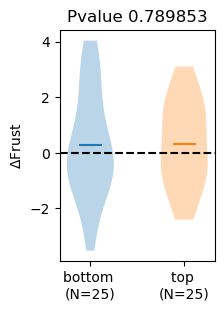

In [33]:
plt.figure(figsize=(2,3))
p=plt.violinplot([diff_frust[:N]],positions=[0],showmeans=True, showextrema=False)
p=plt.violinplot([diff_frust[N:]],positions=[1],showmeans=True, showextrema=False)
plt.xticks([0,1],['bottom \n(N='+str(N)+')','top \n(N='+str(N)+')'])
plt.ylabel(r'$\Delta \text{Frust}$')
#plt.legend(['high\nenrichment\nn='+str(N),'low\nenrichment\nn='+str(N)])
plt.axhline(0,color='k',linestyle='--')
plt.title('Pvalue '+str(np.round(mannwhitneyu(diff_frust[:N],diff_frust[N:])[1],6)))
plt.savefig('Figures/frust_violin_plot_tnsC.svg')